# 一、传输层

这一层是网络栈中非常重要的一层，也是面试中经常考察的一个知识点。在传输层中一共包含两个协议，分别是UDP（用户数据包协议）和TCP（传输控制协议），前者只用了解就可以，后者则是考察的重点，需要重点去掌握。

通常网络层就已经能够保证将报文发送至目标主机，但是通常目标主机上使用网路通信服务的进程不只有一个，因此仅仅将报文发送至目标主机还远远不够，网络栈还应该提供“端到端”的服务，也就是将通信报文发送至目标进程的服务，在传输层中这种服务是通过端口号来实现的。无论是UDP还是TCP在报文头部都有源端口号和目标端口号两个字段，这两个字段都是4个字节，用于标识一个32位的端口号，而端口号又与进行通信的进程绑定（进程通常会监听特定端口号），通过这样的方法就完成了端到端的网络通信。

## `UDP`用户数据报协议

这种协议是一种无连接的传输层协议，也就是说它提供一种不可靠的通信服务，这种协议仅仅提供基础的端到端服务（即通过源端口号和目标端口号实现进程与进程之间通信）以及简单的差错校验。其主要特点包含以下三个方面：

1. UDP是无连接的：这主要是说UDP在通信时没有建立连接这个步骤，同样在结束通信时没有释放连接这个步骤。这一特点通信效率较高。

2. UDP尽最大努力交付：换句话说，这个特点是要告诉我们UDP不保证可靠的通信，如果发生了丢包之类的事情该协议是不管的。

3. UDP是面向报文的：这个特点的意思是当上层的应用程序选择UDP进行通信时给UDP多少数据UDP就会立刻发送多少数据，它不会因为数据过大而将数据拆分，也不会因为数据过少而等待一段时间以使报文达到一定长度后再发送。这一特点导致使用UDP时可能会发生报文过短传输效率过低或者报文过长网络层多次分片传输开销增大。

### `UDP`的数据校验

`UDP`支持数据校验，首先来看`UDP`的首部格式：

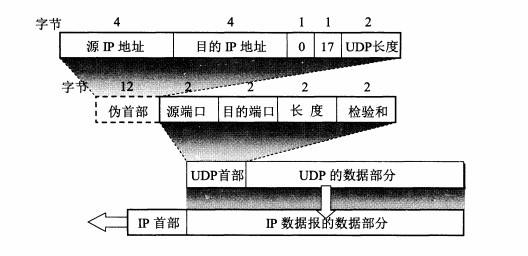

需要注意的是：`UDP`除了真正的首部之外还有一个“伪首部”，这个伪首部仅仅是在计算校验和的时候会用到。在校验数据的时候UDP使用**伪首部**，**首部**以及**数据**三部分计算校验和，将计算好的校验和放入UDP首部的**校验和**字段，以此达到校验数据的目的。UDP是十分简单的传输层协议，虽然只能实现不可靠的数据传输且没有拥塞控制机制，但也正是因为如此UDP能适合一些特殊的应用场景，比如说IP电话，在网络语音通话中由于人的语速是恒定的，因此为了保证通话质量最好不要使用拥塞控制来限制发送速率，而且语音通话中偶尔的信号丢失也是可以容忍的，正是因为以上的特点在网络通话中UDP使用的比较广泛。

## `TCP`传输控制协议

TCP是传输层应用最为广泛的协议了，在阅读《计算机网络》这本书关于TCP协议的介绍中，笔者觉得TCP的核心就是两点：

1. 可靠传输：TCP是要在底层不可靠的通信线路上实现可靠的网络通信，这个要求就是通过TCP协议来实现的，也是TCP要解决的核心问题之一。

2. 拥塞控制：这里的拥塞控制即可以理解为针对目标机器的流量控制，也可以理解为针对网络通信能力的拥塞控制。对于前者，是因为目标机器处理网络请求的能力有限，因此发送端必须针对目标机器的信息处理能力动态调整自己的信息发送速率来避免“发的太快，目标机器无法处理”的情景。而后者是因为网络的通信能力有限，如果不针对网络通信能力进行流量控制可能会造成多个及其同时通信造成网络负荷过高的现象。

TCP协议的特点有以下几点：

1. TCP是面线连接的：这一点和UDP相对，这是说TCP在通信之前需要首先建立连接，在通信完毕时也需要首先释放连接。

2. TCP只支持点对点的通信：UDP支持多播和组播，但是TCP只支持端到端的通信，即TCP不支持多播和组播。

3. TCP提供可靠的通信：这一点又是和UDP相对，这一特点也是TCP最大的特点之一。

4. TCP提供全双工通信：这是说使用TCP通信时通信的双方能够同时发送和接收消息。

5. TCP是面向字节流的：这一点和UDP相对，在TCP中并不是上层的应用程序发送多少数据就传送多少数据而是将这些数据放在一个缓冲当中，然后TCP协议根据当前的条件来发送这些位于缓冲中的字节。

刚才已经说了：TCP提供的是端到端的通信服务。而这个端指的就是套接字（socket），根据RFC793的定义：

>端口号拼接到IP地址即做套接字或插口。

TCP协议的报文首部字段如下所示：

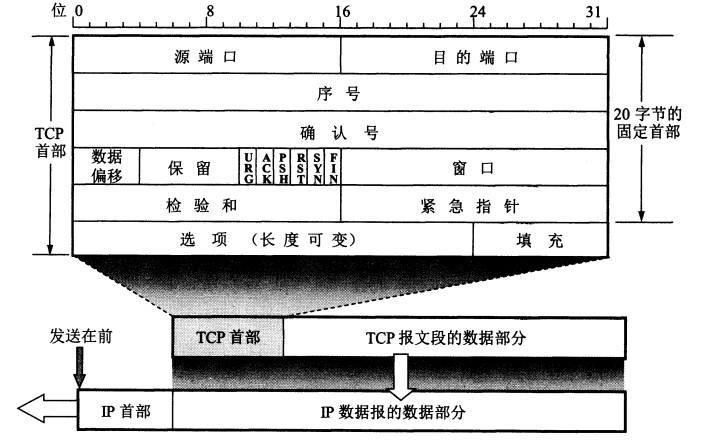

### `TCP`协议的可靠传输实现

TCP协议的可靠传输完全依靠TCP首部的“序号”和“确认号”两个字段来实现，其核心思想就是：发送方发送一个TCP报文，这个报文会有一个序号，接收方在接受到这个报文后需要给发送方发送一个TCP报文并且在“确认号”中标识该报文，告诉发送方已经收到。如果发送方在规定时间内没有收到接受方的确认报文就认为这个报文在传输中丢失了，就会启动重传。

在实际实现的时候TCP协议会维护一个缓冲，应用程序需要发送数据时就将数据放入到缓冲中，TCP会在缓冲中维护一个“发送窗口”，TCP会发送在发送窗口中的数据。缓冲中的数据依据字节进行编号：

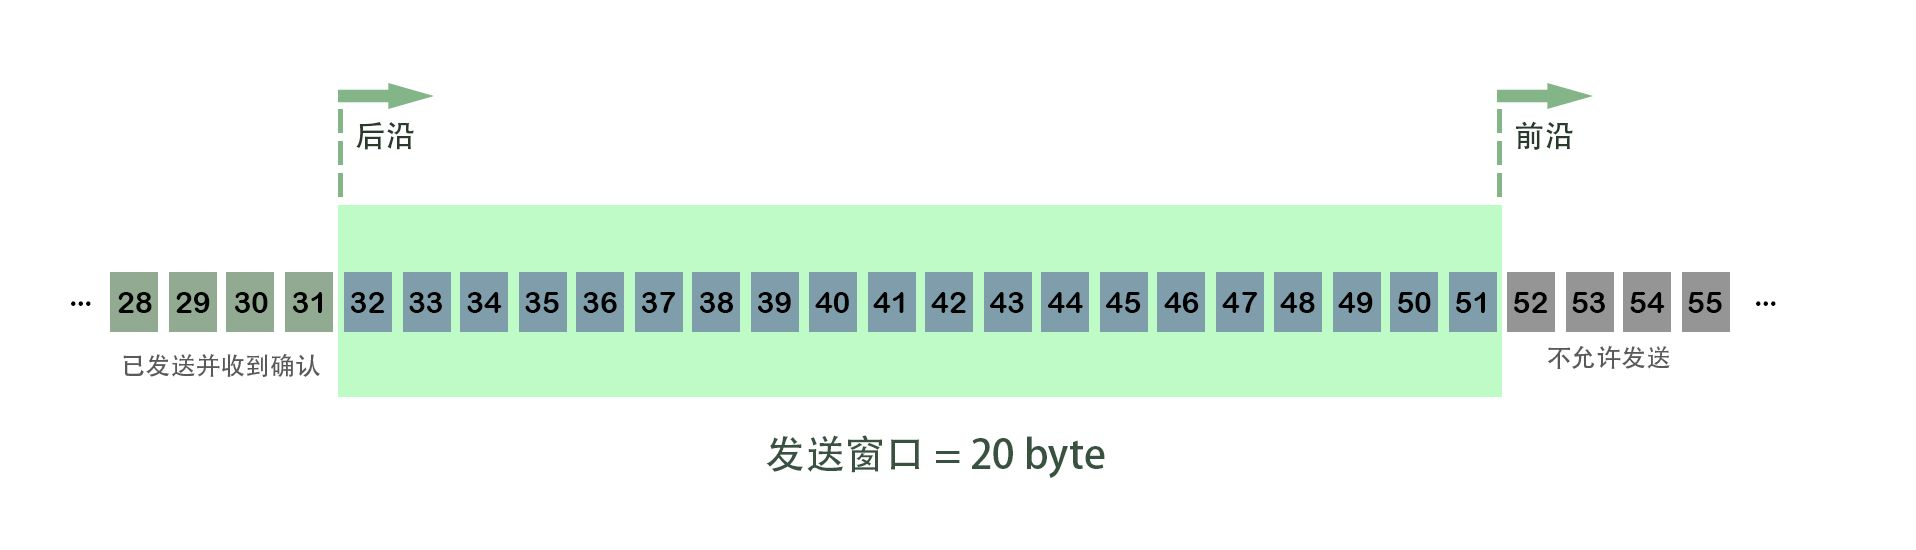

如上图所示：TCP协议每次只发送窗口内部的字节，而且也并不是一次全部都发送出去而是根据实际情况一部分一部分地传送。TCP协议在传送数据时往往一次性传送多个字节。而目标机器在收到发送方法来的报文后需要对收到的报文进行确认，在这里需要说明的是：如果接受方一次性接受到多个报文，且这些报文的序号是连续的话（比如说连续接到了32,33,34三个序号的报文），那么接受方只回复序号最大的那个，代表前面序号小的报文也被接受到了。在实际的应用中，由于每个TCP报文都含有多个字节，而序号又是根据报文中字节序号最小的来确定的，因此即使是相邻的报文其序号也可能不连续，这时接收方需要根据报文的数据长度和序号两个信息来判断多个报文是否是连续的，如果是，那么依旧只确认序号最大的那个，代表前面的都已经收到了。

如果接收方收到了**乱序**的报文，如下图所示：

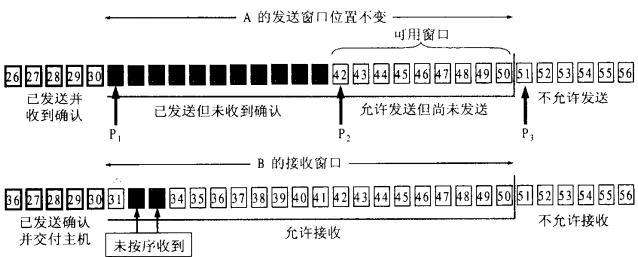

那么接收方则不会发送任何确认信息（也可以选择确认，但基本没有这么做），直到收到了连续的报文信息又或是时间超时后发送方再次发送。如上图所示：发送方在发送了一部分发送窗口内的字节后由于没有收到接受方的确认信息，因此发送窗口并没有向前移动，此时发送窗口内可供发送的信息变少了。如果此时接收到了来自接受方的确认信息，那么发送方的接受窗口的尾指针则会向前移动到已发送但还未确认的字节上，而发送窗口的首指针此时也可以向前移动以维持固定大小的发送窗口。

正是通过这样的机制才保证了TCP协议的可靠传输，还有最后一个问题：发送方如何确定超时等待时间，由于网络环境千变万化，这个值肯定不可能是一个定死的值。TCP选择的方式是测量报文在网络中的平均往返时间（RTT）然后再加权算出一个合适的超时等待时间。

### `TCP`流量控制与拥塞控制

在TCP协议中有流量控制和拥塞控制两种机制来限定发送方的发送速率。通常情况下，发送方的信息发送速率要考虑两个方面的需求：

1. 接受方的接受能力：如果接收方的信息处理能力弱于发送方的信息发送速率那么就可能出现接收方接受不足而大量丢包导致发送方不断重传的困境，这无疑会极大地降低通信效率。这时就需要发送方进行流量控制。

2. 网络环境的通信能力：网络基础设施的通信能力是有限的，如果当前网络的通信能力已经达到很高负荷，那么正常的操作就应该是让发送方降低发送速率，使网络的负载尽可能的降低以提升网络吞吐量，这时候就需要进行网络的拥塞控制。

#### 流量控制

在TCP协议的首部字段中，有一个**窗口**字段。该字段是说明发送次报文的主机当前能够接受的接受窗口大小，换句话说就是还能接受多少个字节的数据，接收方使用这个字段来表明此时接受主机的信息处理能力。当发送方接收到接收方的确认报文时会检查该报文的窗口字段，确认现在接收方的接受窗口大小，然后再调整自身发送窗口的大小以适应接受方的处理能力。

但是需要考虑这样一种情况，如果某一时刻接受方的处理能力变为0并且向发送方发送了窗口数值为0的确认报文，发送方收到了这个报文并且将发送窗口调整为0。紧接着，接受方的接受窗口又变大了并且向发送方又发送了一个窗口值不为0的确认报文，但是这个报文并没有被发送方接收到，那么此时就有可能产生“死锁”的情况。TCP在面对这种问题时的解决方案是：发送方在收到窗口值为0的确认报文后停止发送报文，并且每隔一段时间发送一个很小的探测报文，接收方在得到这个探测报文后向发送方发送确认报文，其中的窗口字段表明此时的接受窗口。TCP使用这种方式来避免“死锁”情况。

#### 拥塞控制

拥塞控制是针对于网络堵塞情况而言的发送方发送速率控制措施。拥塞控制的必要性就不多说了，应该是十分明白的，这里有几种非常经典的拥塞控制算法：

1. 慢开始：为了避免网络通信一开始就出现网络堵塞，发送窗口在通信开始时是一个表较小的数值，然后发送方每接到一个确认报文就将窗口值增大1，这样发送窗口之就会以指数形式增长（这一点很好理解：通信伊始窗口为1，发送一个报文也接到了一个报文，那么窗口值变为2，此时发送两个报文也接到了两个确认报文，此时就要将窗口值加2变为4,以此类推）。

2. 拥塞避免：当使用慢开始算法将发送窗口增长至某个门限值时窗口便不再以指数形式增长而变为线性增长。当发送窗口达到某个值后出现丢包情况说明网络可能发生拥塞，此时TCP将门限值设定为当前发生拥塞窗口值的一半，并且将发送窗口的值设定为1,，然后再次启动慢开始算法。

上面的过程用图的形式表现如下：

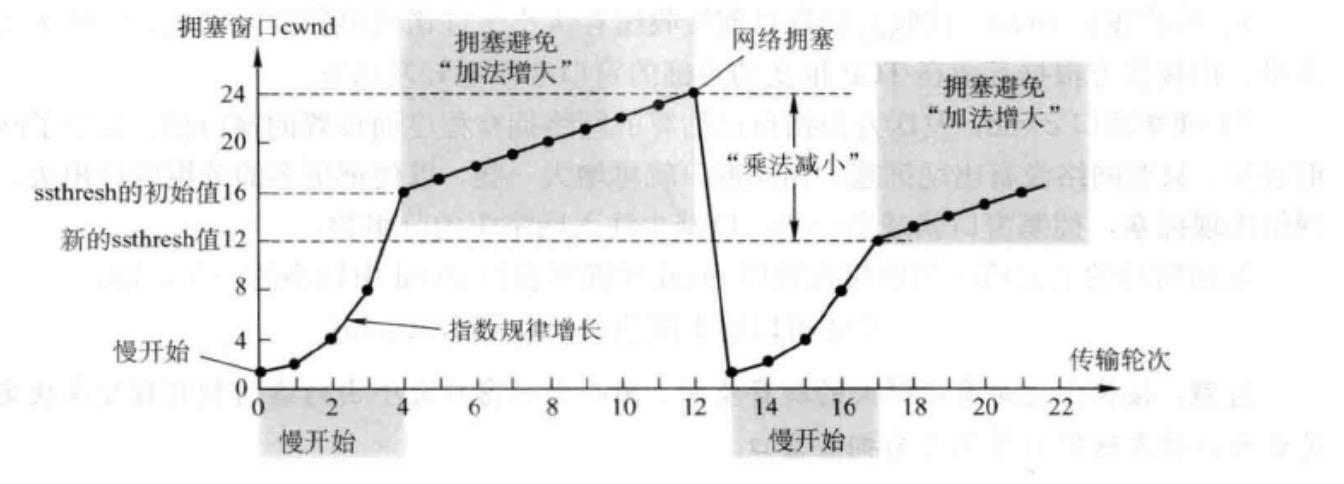

慢开始和拥塞避免算法可以有效避免网络拥塞，但是这种算也有一些短板那就是在拥塞避免阶段将发送窗口值减得太小导致传送效率较低，因此在原有基础上又提出了新的两种算法：

1. 快重传：在可靠传输一小节中，我们知道当TCP接收方收到了一个失序报文是可以什么都不做的，发送方在一定的时间间隔没有收到确认报文后就会启动重传，这样的设定有一个弊病就是发送方等待的超时时间会被完全浪费掉。快重传的机制就是当接收方接受到一个失序报文时向发送方确认最近一个有序报文，如果发送方在连续接到三个这样的确认报文就会立刻启动重传而不等待超时计数器超时。这一措施可以让通信效率增加20%。

2. 快恢复：当发送方收到3个相同的确认报文启动重传时可以认为网络有一定概率发生拥塞（之所以是一定概率是因为如果确定拥塞那么发送方不可能接收到连续三个相同的确认报文）则将门限值减小为当前窗口值的一般并且减小发送窗口值。与拥塞避免算法不同的是：此时窗口值并不减小为1而是见小为当前缩小过后的门限值，并且执行发送窗口线性增长算法。

以上过程用图表示如下：

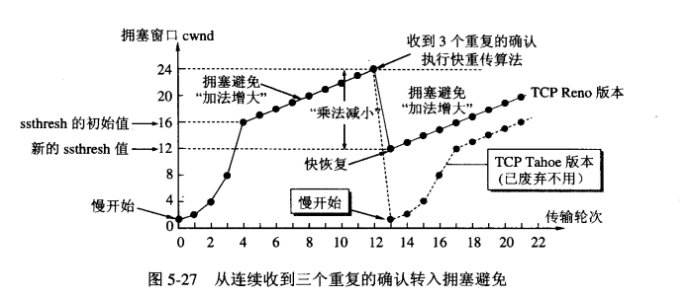

无论在流量控制还是拥塞控制中，发送方发送速率的改变都是通过发送窗口大小的改变这一机制来实现的，也就是说流量控制机制会改变发送窗口大小，拥塞控制机制也会改变发送窗口大小，那么发送窗口大小在实际设定的时候应该遵守哪一个呢？为了稳定起见，通常将发送方的发送窗口设定为流量控制给出窗口值大小和拥塞控制给出窗口值大小之中较小的那一个。

## `TCP`的三次握手与四次挥手

这两个过程是非常著名的也是面试中非常喜欢考察的，本身过程非常简单使用过程图就能够让人明白，这里就不用文字进行说明了。

### 三次握手

首先是TCP三次握手的过程图：

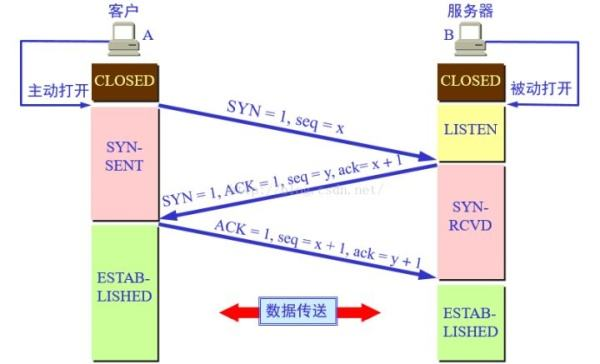

在三次握手中容易查考的点是为什么需要三握手，也就是说第三次握手存在的意义。这主要是为了防止“已失效的连接请求报文段”造成的影响。想象这样一种情景：客户机发送了连接请求报文，但是由于种种原因这个报文没有及时到达服务器而是阻塞在网络的某个角落，过了一段时间客户端启动了重传，这一次服务器及时接收到了该报文并且确认报文客户端也受到了，如果只有两次握手那么此时TCP连接就已经建立了。一段时间后，本次TCP通信完成了，双方都释放了连接，但此时客户机第一次发送的连接报文到达了服务器，此时服务器以为客户机又要建立连接那么服务器会发送一个确认报文并进入连接建立状态，由于客户机本身并不想建立连接因此并不会进行通信，那么此时就会出现服务器“干等”客户机通信而白白消耗资源的情况。

第三次握手的必要性就体现在这里：服务器回应了那个“过期”的请求连接报文后并不会马上进入到连接建立阶段，而是会等待客户机回应，如果等待一段时间而没有回应那么服务器就会释放连接以达到避免资源消耗的目的。其实在DDOS攻击中很多就是通过向目标服务器发送“虚连接”来达成的，攻击者向目标机器发送一个TCP连接请求，在收到了服务器的确认报文后又不回应让服务器长久地停留在`SYN-RCVD`状态，以此来达到消耗服务器资源的目的，如果只用两次握手那么这样的攻击可以说是无法可解，但是如果使用三次握手则多少可以避免这种打击。

### 四次挥手

四次挥手是TCP释放连接时的操作，其过程图如下所示：

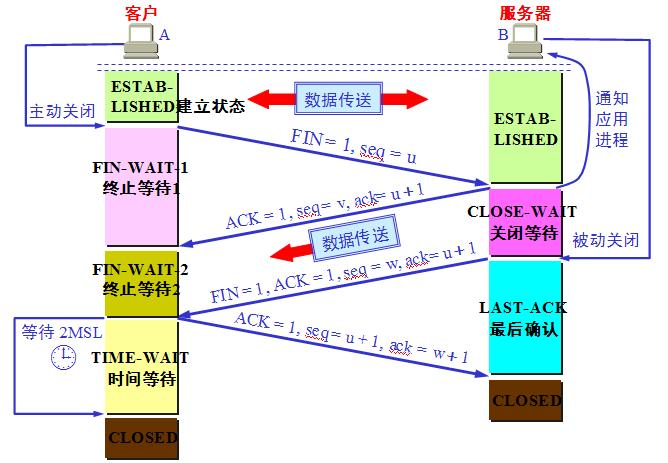

四次挥手容考察的点有以下几个：

1. 为什么服务器也要发送一次连接中止并等待客户机回应后才关闭连接：这是因为TCP是全双工通信的，也就是说服务器也会发送数据给客户机，当客户机发起连接中止请求的时候服务器可能还有没有发送完的数据，因此客户机必须进入`FIN-WAIT-1`状态等待服务器未发送完的数据发送完成。由于网络是不可靠的，因此服务器并不确定让客户机关闭连接的保温是否到达了客户机，因此需要收到客户机的确认报文后才关闭，如果一段时间后没有收到那么就会启动重传，这也是出于保护客户及资源的目的。

2. 为什么客户机在确认了服务器的连接中止报文后还需要等待2MSL：这是因为客户机不确定服务器是否收到了这个确认报文，如果服务器没有收到就会在一段时间后启动重传，如果此时客户机不等待2MSL而是直接关闭了连接就肯定无法对这个重传报文进行回应，那么服务器就会一直卡在`LAST-ACK`阶段空耗资源。客户机等待2MSL就是为了让所有的报文都尽可能地消失在网络中以保护服务器资源。**注：一个MSL为2分钟**